In [1]:
import os
import ast
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

**Скачаем датасет и разархивируем его.**

In [3]:
os.mkdir('../data')

In [4]:
!python -m wget "https://drive.google.com/u/0/uc?id=1cYj0VMxyLyZsdrXW72fftBGzkCYmfzVU&export=download&confirm=t&uuid=baf858b2-4a0a-4d43-a8b4-e641d57d4431" -o ../data/data.zip


Saved under ../data/data.zip


In [5]:
!python -m zipfile -e ../data/data.zip ../data/

In [6]:
os.remove("../data/data.zip")

**Считаем данные в pandas.DataFrame**

In [359]:
data = pd.read_csv('../data/data.csv')
handbook = pd.read_csv('../data/handbook.csv')

In [360]:
data.rename(columns={'Идентификатор филиалы документа': 'Идентификатор филиала'}, inplace=True)
data.head(5)

,Идентификатор документа,Идентификатор товара,Вид операции документа,Дата документа,Идентификатор филиала
0,b'\x8f\x03\xf0[gd\xef.P\xb0\\P\xe8f\xb6\x9f',b'\xee\xdf\xa5\xb3\x1f\xe5\x81\x18\x1e\x86j\xe...,Прием товара,2019-01-01,b'\xe1\xdb\xd1\x95\x93\x7f\x17\x7f\xcd\xea\x7f...
1,b'O\x99\x903\x11Zd\x16\x8e\x00\xafM\xb8\x02\xa...,b'a\xad\xa7qJ\x9eW\x15<H\xd5U\x82\xc3-\x04',Прием товара,2019-01-01,b'\xca\xbc\x12\xca\x94?^\x94B\x93\x16\xd8\xf7\...
2,b'\xc3y\xdc\xf9\xc9\xe1\x0cC\x13U\xdby\xac\x97...,b'U\xb8J-\xa7\xae\xe0\xe2\x1a.\x0c\xaf\xfe\x80...,Прием товара,2019-01-01,b']\xe0\xf1p\xff!8x\xb9\xea\xee\xc2P\xcb\xd8\x93'
3,b'9\xf4D`\x00\xf0\x00\xe3\xa8=\xea=N$\xf2\xc9',b'\xf0\x8a\x8f\xe5\xb1\xd4\xd8\xbd\xcc\xb8\x1d...,Прием товара,2019-01-01,b'\x1eF\xdfq\x18\xc5\x8c\x19\xd5\x014\xd7\xef\...
4,b'\x10\x0b?\xd9ehT\x181\xed\xdd}\x1c(\x98`',b'\x10\xf0\x9c\xf6\xd2\x9d\xde\xc08\xde\xa74u\...,Прием товара,2019-01-01,"b'\xfd,{d\x07""\x8c\x0eT\x997\xdcS\x82\xac\xcd'"


In [361]:
handbook.rename(columns={'Наименование региона филиала': 'Наименование региона'}, inplace=True)
handbook.head(5)

,Наименование филиала,Наименование региона,Идентификатор филиала
0,Казань СЦ на Чистопольской,Верхняя Волга,"b'U\x8b\xecN\xb5\xe4\x02+\xcf\x9cT""ivr\n'"
1,Воткинск СЦ,Верхняя Волга,b'\xb5Mv\xe3\x86\xc3\x9a\x0b\x10\xb2\xba\xfa\x...
2,Чистополь СЦ,Верхняя Волга,"b'\xfd,{d\x07""\x8c\x0eT\x997\xdcS\x82\xac\xcd'"
3,Тверь СЦ,Центральный,b'\xe4\x04!)\xa7l\xb0B#=i\xf8\x89\x1a\x8b\x1f'
4,Рославль СЦ,Черноземье,b'\xb85\xa2\xe7\x1b\x8d\xd5\xff\x0bd>\xdcR:\xd...


**Для удобства:**

In [362]:
doc_id = 'Идентификатор документа'
prod_id = 'Идентификатор товара'
filial_id = 'Идентификатор филиала'

doc_date = 'Дата документа'

months = 'Месяцы'
weeks = 'Недели'
days = 'Дни'

region_name = 'Наименование региона'

**Видим, что идентификаторы записаны в виде строк байт.**

Их можно преобразовать в следующий вид:

In [363]:
identifier = ast.literal_eval(data[doc_id][0])

big = int.from_bytes(identifier, 'big')
little = int.from_bytes(identifier, 'little')

print(big, 'или', little)

190100055307885217600600356315355068063 или 212294336569639092776542131814963086223


**Но для выполнения задания это не обязательно, лучше преобразуем столбец с датой документов в datetime.**

In [364]:
data[doc_date] = pd.to_datetime(data[doc_date])

**Заметим, что у нас есть дата приёма и выдачи товара, зная эту информацию можно рассчитать время хранения товара в сервисном центре.**

Сгруппируем данные по идентификатору товара и выберем дату документа, тем самым получим дату приема и выдачи для каждого товара.

Также возьмём идентификатор филиала, он нам понадобится. (идентификатор филиала для каждого товара единственный)

In [365]:
# Сгруппируем данные с помощью pandas

filials = data.groupby(prod_id)[filial_id].unique().apply(list)
storage_time = data.groupby(prod_id)[doc_date].apply(list)

storage_time = pd.concat([storage_time, filials], axis=1)

**Заметим, что группировка выполняется долго. (около 2-3 минут)**

Сделаем алгоритм побыстрее: 

In [366]:
from collections import defaultdict

storage_time, filials = defaultdict(list), {}

for row in data[[prod_id, doc_date, filial_id]].values:
    storage_time[row[0]].append(row[1])
    filials[row[0]] = row[2]

**Создадим новый pandas.DataFrame с которым будем работать в дальнейшем.**

In [367]:
storage_time = pd.DataFrame(storage_time.items(), columns=[prod_id, doc_date])
storage_time[filial_id] = storage_time[prod_id].map(filials)

In [368]:
storage_time.head(5)

,Идентификатор товара,Дата документа,Идентификатор филиала
0,b'\xee\xdf\xa5\xb3\x1f\xe5\x81\x18\x1e\x86j\xe...,"[2019-01-01 00:00:00, 2019-01-20 00:00:00]",b'\xe1\xdb\xd1\x95\x93\x7f\x17\x7f\xcd\xea\x7f...
1,b'a\xad\xa7qJ\x9eW\x15<H\xd5U\x82\xc3-\x04',"[2019-01-01 00:00:00, 2019-01-18 00:00:00]",b'\xca\xbc\x12\xca\x94?^\x94B\x93\x16\xd8\xf7\...
2,b'U\xb8J-\xa7\xae\xe0\xe2\x1a.\x0c\xaf\xfe\x80...,"[2019-01-01 00:00:00, 2019-02-04 00:00:00]",b']\xe0\xf1p\xff!8x\xb9\xea\xee\xc2P\xcb\xd8\x93'
3,b'\xf0\x8a\x8f\xe5\xb1\xd4\xd8\xbd\xcc\xb8\x1d...,"[2019-01-01 00:00:00, 2019-01-27 00:00:00]",b'\x1eF\xdfq\x18\xc5\x8c\x19\xd5\x014\xd7\xef\...
4,b'\x10\xf0\x9c\xf6\xd2\x9d\xde\xc08\xde\xa74u\...,"[2019-01-01 00:00:00, 2019-01-09 00:00:00]","b'\xfd,{d\x07""\x8c\x0eT\x997\xdcS\x82\xac\xcd'"


**Так как у нас есть товар, у которого нет операции выдачи, то будем считать, что товар хранится до сегодняшнего дня.**

Конечно, можно игнорировать товар у которого нет документа о выдачи и считать, что он не подлежит выдачи, но это нужно обговорить.

In [369]:
storage_time.loc[(storage_time[doc_date].agg(len) == 1), doc_date].agg(lambda x: x.append(np.datetime64('today')))
storage_time

,Идентификатор товара,Дата документа,Идентификатор филиала
0,b'\xee\xdf\xa5\xb3\x1f\xe5\x81\x18\x1e\x86j\xe...,"[2019-01-01 00:00:00, 2019-01-20 00:00:00]",b'\xe1\xdb\xd1\x95\x93\x7f\x17\x7f\xcd\xea\x7f...
1,b'a\xad\xa7qJ\x9eW\x15<H\xd5U\x82\xc3-\x04',"[2019-01-01 00:00:00, 2019-01-18 00:00:00]",b'\xca\xbc\x12\xca\x94?^\x94B\x93\x16\xd8\xf7\...
2,b'U\xb8J-\xa7\xae\xe0\xe2\x1a.\x0c\xaf\xfe\x80...,"[2019-01-01 00:00:00, 2019-02-04 00:00:00]",b']\xe0\xf1p\xff!8x\xb9\xea\xee\xc2P\xcb\xd8\x93'
3,b'\xf0\x8a\x8f\xe5\xb1\xd4\xd8\xbd\xcc\xb8\x1d...,"[2019-01-01 00:00:00, 2019-01-27 00:00:00]",b'\x1eF\xdfq\x18\xc5\x8c\x19\xd5\x014\xd7\xef\...
4,b'\x10\xf0\x9c\xf6\xd2\x9d\xde\xc08\xde\xa74u\...,"[2019-01-01 00:00:00, 2019-01-09 00:00:00]","b'\xfd,{d\x07""\x8c\x0eT\x997\xdcS\x82\xac\xcd'"
...,...,...,...
1499780,b'\xa5p\xcb\xf8\xed\xbc\x94<\x17w\x98}\x18UQ\x84',"[2019-12-31 00:00:00, 2022-08-13]",b'tt\xc7\xd0\x03\xe0RT\x89n\x18u]N\x00C'
1499781,"b'>\xeey\xe9%o\xd4Y/\xef""S\x01\xfal\xd3'","[2019-12-31 00:00:00, 2022-08-13]",b'\xa0\xdcn\xfa\xa0zwv<*\x8b\n\x13\x8c!\xd5'
1499782,"b""4\xbe\xdf\xdc\n\xf4b\x9ay\xb1\x8c'\xd5\xa8\x...","[2019-12-31 00:00:00, 2022-08-13]",b'\xaa\xd7G\x1e\x96\xdb\xb1\xea\xc0\xd6\xc6\xd...
1499783,b'\x89\x8df\x02\x8d\xc2(\xc9\x17M4\xb9\xe9\x9a...,"[2019-12-31 00:00:00, 2022-08-13]",b'_\xc8\xf5\xdd\xb5\xf8\xddn\xcb\x05\xf4\x1d\x...


**Вычислим сколько дней, недель и месяцев товар пробыл в сервисном центре.**

Считаем недели и месяцы с дробной частью для более точной интерпретации.

In [370]:
storage_time[days] = storage_time[doc_date].apply(lambda x: x[1] - x[0])

storage_time[weeks] = storage_time[days] / np.timedelta64(7, 'D')
storage_time[months] = storage_time[days] / np.timedelta64(31, 'D')
storage_time[days] = (storage_time[days] / np.timedelta64(1, 'D'))

storage_time = storage_time.drop(doc_date, axis=1)

In [371]:
storage_time.head(5)

,Идентификатор товара,Идентификатор филиала,Дни,Недели,Месяцы
0,b'\xee\xdf\xa5\xb3\x1f\xe5\x81\x18\x1e\x86j\xe...,b'\xe1\xdb\xd1\x95\x93\x7f\x17\x7f\xcd\xea\x7f...,19.0,2.714286,0.612903
1,b'a\xad\xa7qJ\x9eW\x15<H\xd5U\x82\xc3-\x04',b'\xca\xbc\x12\xca\x94?^\x94B\x93\x16\xd8\xf7\...,17.0,2.428571,0.548387
2,b'U\xb8J-\xa7\xae\xe0\xe2\x1a.\x0c\xaf\xfe\x80...,b']\xe0\xf1p\xff!8x\xb9\xea\xee\xc2P\xcb\xd8\x93',34.0,4.857143,1.096774
3,b'\xf0\x8a\x8f\xe5\xb1\xd4\xd8\xbd\xcc\xb8\x1d...,b'\x1eF\xdfq\x18\xc5\x8c\x19\xd5\x014\xd7\xef\...,26.0,3.714286,0.838710
4,b'\x10\xf0\x9c\xf6\xd2\x9d\xde\xc08\xde\xa74u\...,"b'\xfd,{d\x07""\x8c\x0eT\x997\xdcS\x82\xac\xcd'",8.0,1.142857,0.258065


**Объединим pandas.DataFrame по идентификатору филиала.**

In [372]:
storage_time = pd.merge(storage_time, handbook, on=filial_id)
storage_time.head(5)

,Идентификатор товара,Идентификатор филиала,Дни,Недели,Месяцы,Наименование филиала,Наименование региона
0,b'\xee\xdf\xa5\xb3\x1f\xe5\x81\x18\x1e\x86j\xe...,b'\xe1\xdb\xd1\x95\x93\x7f\x17\x7f\xcd\xea\x7f...,19.0,2.714286,0.612903,Невинномысск СЦ,Юг
1,"b'\xe4\xc6M\x06q,6K\x0c53\xf0\x8d\xaa\x92E'",b'\xe1\xdb\xd1\x95\x93\x7f\x17\x7f\xcd\xea\x7f...,23.0,3.285714,0.741935,Невинномысск СЦ,Юг
2,b'\r\xeb\x1c6.\xc4|\x0f\x86\xc4\x0f\x8c\x89\xe...,b'\xe1\xdb\xd1\x95\x93\x7f\x17\x7f\xcd\xea\x7f...,29.0,4.142857,0.935484,Невинномысск СЦ,Юг
3,b'\x1288\xae\xa6\xaaJ\xd1q\xe3J\xdd#M\xe1\xae',b'\xe1\xdb\xd1\x95\x93\x7f\x17\x7f\xcd\xea\x7f...,28.0,4.000000,0.903226,Невинномысск СЦ,Юг
4,b'\xbd\xfdh33xze\x13\x1d\xbd\x119\x96m\xb9',b'\xe1\xdb\xd1\x95\x93\x7f\x17\x7f\xcd\xea\x7f...,18.0,2.571429,0.580645,Невинномысск СЦ,Юг


**Рассчитаем среднее время нахождения товара в сервисном центре.**

Построим гистограмму распределения по месяцам.

<AxesSubplot:xlabel='Время хранения по месяцам', ylabel='Количество товаров'>

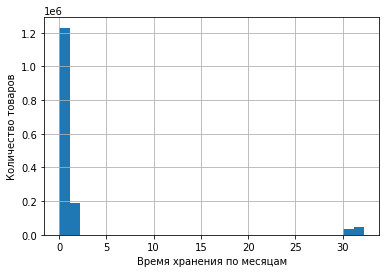

In [377]:
plt.xlabel('Время хранения по месяцам')
plt.ylabel('Количество товаров')
storage_time[months].hist(bins=30)

**Видим, что гистограмма разделяется на две части, где время нахождения ~30 месяцев, это тот самый товар без документа выдачи.**

Если мы посчитаем среднее время нахождения товара в таком виде, то время нахождения ~30 месяцев будет увеличивать среднее значение.

In [378]:
print('Среднее время нахождения товара в сервисном центре:')
print('Месяцы', f'{storage_time[months].mean():.{2}f}')
print('Недели', f'{storage_time[weeks].mean():.{2}f}')
print('Дни', round(storage_time[days].mean()))

Среднее время нахождения товара в сервисном центре:
Месяцы 2.36
Недели 10.47
Дни 73


**Отфильтруем значения, где время нахождения ~30 месяцев.**

Отфильтровав эти значения, получим более точную оценку среднего.

<AxesSubplot:xlabel='Время хранения по месяцам', ylabel='Количество товаров'>

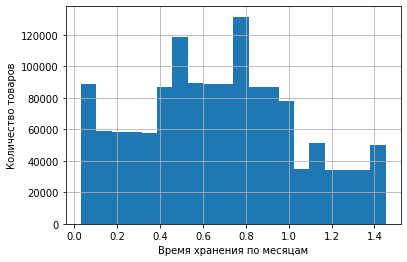

In [379]:
new_storage_time = storage_time[storage_time[months] < 25]

plt.xlabel('Время хранения по месяцам')
plt.ylabel('Количество товаров')
new_storage_time[months].hist(bins=20)

In [380]:
print('Среднее время нахождения товара в сервисном центре:')
print('Месяцы', f'{new_storage_time[months].mean():.{2}f}')
print('Недели', f'{new_storage_time[weeks].mean():.{2}f}')
print('Дни', round(new_storage_time[days].mean()))

Среднее время нахождения товара в сервисном центре:
Месяцы 0.67
Недели 2.98
Дни 21


**Найдем динамику по месяцам и неделям в разрезе регионов.**

In [381]:
new_storage_time.groupby(region_name)[[months, weeks]].mean()

,Месяцы,Недели
Наименование региона,,
Верхняя Волга,0.581906,2.577012
Восточная Сибирь,0.718832,3.183397
Дальний Восток,0.837050,3.706938
Западная Сибирь,0.718371,3.181356
Приволжский,0.581338,2.574496
Средняя Волга,0.771928,3.418538
Урал,0.735936,3.259144
Центральный,0.670802,2.970696
Черноземье,0.582084,2.577801


**Выведем нормативный срок хранения по всей компании.**

Возьмем нормативный срок хранения товара в сервисном центре как среднеарифметическое по дням и округлим его.

<AxesSubplot:xlabel='Время хранения по дням', ylabel='Количество товаров'>

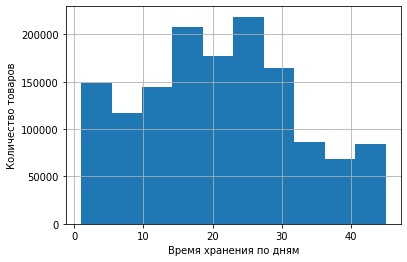

In [382]:
plt.xlabel('Время хранения по дням')
plt.ylabel('Количество товаров')
new_storage_time[days].hist()

In [383]:
std_storage_time = round(new_storage_time[days].mean())
print('Нормативный срок хранения -', std_storage_time, 'день.')

Нормативный срок хранения - 21 день.


**Графически представим динамику отклонения от нормы по каждому региону.**

In [384]:
storage_time_by_region = new_storage_time.groupby(region_name)[[days]].mean().apply(list)

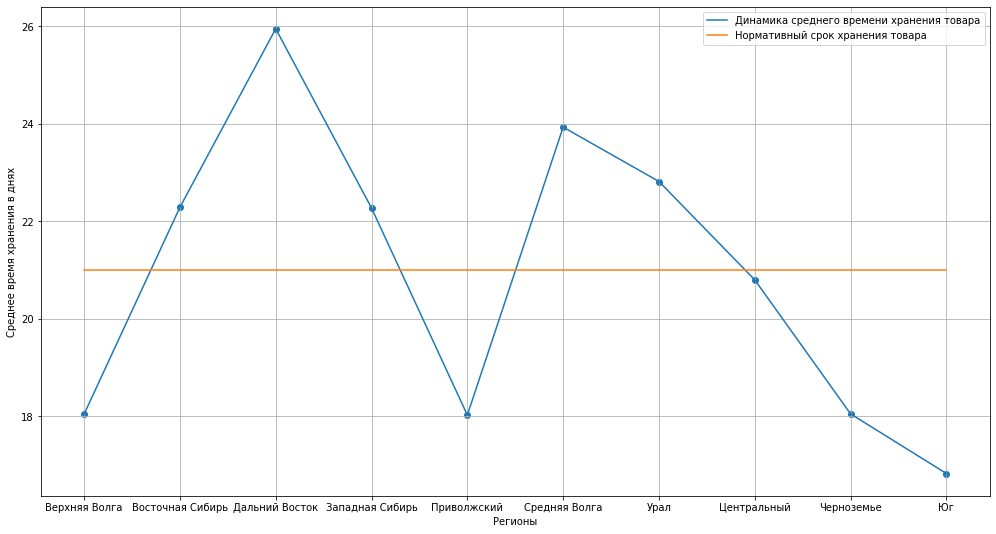

In [386]:
plt.figure(figsize=(17, 9))
plt.xlabel('Регионы')
plt.ylabel('Среднее время хранения в днях')

plt.scatter(storage_time_by_region.index, storage_time_by_region.values)
plt.plot(storage_time_by_region.index, storage_time_by_region.values, label='Динамика среднего времени хранения товара')
plt.plot(storage_time_by_region.index, [std_storage_time] * storage_time_by_region.size, label='Нормативный срок хранения товара')

plt.legend()
plt.grid()